In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/4995_final_project/'

/content/drive/MyDrive/4995_final_project


In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import  DataLoader
#
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
#
import dataTools as D
import tools as T
from datetime import datetime
import os
#pi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%precision 5

'%.5f'

Device management.

In [ ]:
# Set some global constants:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  torch.cuda.empty_cache()

True
1
cuda:0


Dataset file preparation.

In [ ]:
!ls

archive.zip  dataTools.py      models.py     __pycache__  training2.ipynb
data	     img_align_celeba  newModels.py  tools.py	  training.ipynb


In [ ]:
# !unzip archive.zip -d data

In [ ]:
# Generates list of file names to conform to CelebA dataset naming format
def generate_img_names_list(n):
    res = []
    
    for i in range(1, n+1):
        num_zeros = len(str(202599)) - len(str(i))
        res.append('0'*num_zeros + str(i) + '.jpg')
    return res

In [ ]:
# Generate list of shuffled file names that correspond to train, validate, test and save them
import random

nCeleb = 20000 # 202599
files = generate_img_names_list(nCeleb)
shuffled_files = random.sample(files, len(files))
database_name = 'CelebA'

if database_name == 'CelebA':
    batch_size = 100
    root = 'data/img_align_celeba/img_align_celeba'
    img_names_list_train = shuffled_files[0 : int(0.8*nCeleb)]
    img_names_list_valid = shuffled_files[int(0.8*nCeleb)+1 : int(0.9*nCeleb)]
    img_names_list_test = shuffled_files[int(0.9*nCeleb)+1: ]
    img_size = (3, 128, 128)
elif database_name == 'CYale':
    root = '/path/to/CYale/'
    img_names_list_test = './dataset_splits/CYale/CYale_test.txt'  
    img_size = (1, 168, 192)
num_channel = img_size[0]   

Data loader initialization.

In [ ]:
num_epoch = 10
batch_size = 32

# Initialize the dataset objects
dataset_train = D.imgRead_fromList(root, img_names_list_train, img_size)
dataset_valid = D.imgRead_fromList(root, img_names_list_valid, img_size)
dataset_test = D.imgRead_fromList(root, img_names_list_test, img_size)

# Initialize the dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
from torchvision.models import vgg16, VGG16_Weights
tmp_model = vgg16(VGG16_Weights)
tmp_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Model initialization and transfer learning

In [ ]:
def find_training_params(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad:
      params_to_update.append(param)
  return params_to_update

In [ ]:
'''sizes = [3, 64, 128, 256, 512]
strides = [1, 1, 1, 1, 1]
num_codes = 20
neck_dim = 512
k = 256
############
from newModels import Autoencoder
net = Autoencoder(img_size, sizes, num_codes, neck_dim, strides, k).to(device)
print(net)'''

'sizes = [3, 64, 128, 256, 512]\nstrides = [1, 1, 1, 1, 1]\nnum_codes = 20\nneck_dim = 512\nk = 256\n############\nfrom newModels import Autoencoder\nnet = Autoencoder(img_size, sizes, num_codes, neck_dim, strides, k).to(device)\nprint(net)'

In [ ]:
num_blocks = 5
# num_filts = [64, 64, 64, 64, 12]
num_filts = [64, 128, 256, 512, 12]
scale_factor = [1, 1, 1, 1, 1]
num_codes = 20
neck_dim = 512
k = 256
############
from models import Autoencoder
net = Autoencoder(img_size, num_blocks, num_filts, scale_factor, num_codes, neck_dim, k).to(device)
print(net)

Autoencoder(
  (encoder): Encoder(
    (downBlocks_I): ModuleList(
      (0): downConvBlock_I(
        (resConv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): downConvBlock_I(
        (resConv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): downConvBlock_I(
        (resConv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
def loss_function(x_rec, x):
    loss_BCE = nn.BCELoss()
    #loss_MSE = nn.MSELoss()
    return loss_BCE(x_rec, x)

optimizer = optim.Adam(net.parameters(), lr=0.002,weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', verbose=True, factor=0.99, min_lr=0.000001,patience=num_epoch)

---------------- epoch =  1 / 10  ----------
b(0): l = 0.718 | b(1): l = 0.775 | b(2): l = 0.816 | b(3): l = 0.655 | b(4): l = 1.042 | b(5): l = 0.660 | b(6): l = 0.691 | b(7): l = 0.597 | b(8): l = 0.628 | b(9): l = 0.599 | b(10): l = 0.583 | b(11): l = 0.596 | b(12): l = 0.567 | b(13): l = 0.583 | b(14): l = 0.553 | b(15): l = 0.550 | b(16): l = 0.569 | b(17): l = 0.573 | b(18): l = 0.546 | b(19): l = 0.572 | b(20): l = 0.555 | b(21): l = 0.546 | b(22): l = 0.541 | b(23): l = 0.555 | b(24): l = 0.550 | b(25): l = 0.525 | b(26): l = 0.525 | b(27): l = 0.541 | b(28): l = 0.542 | b(29): l = 0.546 | b(30): l = 0.528 | b(31): l = 0.513 | b(32): l = 0.510 | b(33): l = 0.556 | b(34): l = 0.537 | b(35): l = 0.519 | b(36): l = 0.523 | b(37): l = 0.532 | b(38): l = 0.522 | b(39): l = 0.543 | b(40): l = 0.558 | b(41): l = 0.546 | b(42): l = 0.518 | Epoch 00044: reducing learning rate of group 0 to 1.9800e-03.
b(43): l = 0.522 | b(44): l = 0.541 | b(45): l = 0.533 | b(46): l = 0.547 | b(47): l =

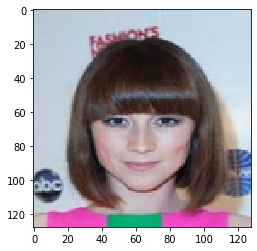

(3, 128, 128)


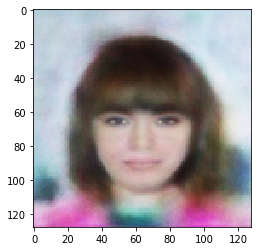

---------------- epoch =  2 / 10  ----------
b(0): l = 0.489 | b(1): l = 0.501 | b(2): l = 0.480 | b(3): l = 0.495 | b(4): l = 0.479 | b(5): l = 0.490 | Epoch 00507: reducing learning rate of group 0 to 1.3379e-03.
b(6): l = 0.505 | b(7): l = 0.480 | b(8): l = 0.507 | b(9): l = 0.482 | b(10): l = 0.478 | b(11): l = 0.480 | b(12): l = 0.495 | b(13): l = 0.489 | b(14): l = 0.461 | b(15): l = 0.514 | b(16): l = 0.511 | Epoch 00518: reducing learning rate of group 0 to 1.3246e-03.
b(17): l = 0.489 | b(18): l = 0.498 | b(19): l = 0.525 | b(20): l = 0.490 | b(21): l = 0.482 | b(22): l = 0.499 | b(23): l = 0.460 | b(24): l = 0.478 | b(25): l = 0.493 | b(26): l = 0.478 | b(27): l = 0.502 | Epoch 00529: reducing learning rate of group 0 to 1.3113e-03.
b(28): l = 0.488 | b(29): l = 0.479 | b(30): l = 0.503 | b(31): l = 0.481 | b(32): l = 0.505 | b(33): l = 0.464 | b(34): l = 0.485 | b(35): l = 0.497 | b(36): l = 0.501 | b(37): l = 0.464 | b(38): l = 0.487 | Epoch 00540: reducing learning rate of

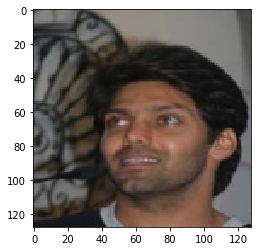

(3, 128, 128)


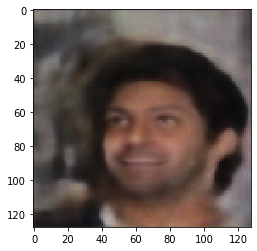

---------------- epoch =  3 / 10  ----------
Epoch 01009: reducing learning rate of group 0 to 8.5118e-04.
Epoch 01020: reducing learning rate of group 0 to 8.4267e-04.
Epoch 01031: reducing learning rate of group 0 to 8.3424e-04.
Epoch 01042: reducing learning rate of group 0 to 8.2590e-04.
Epoch 01053: reducing learning rate of group 0 to 8.1764e-04.
Epoch 01064: reducing learning rate of group 0 to 8.0946e-04.
Epoch 01075: reducing learning rate of group 0 to 8.0137e-04.
Epoch 01086: reducing learning rate of group 0 to 7.9336e-04.
Epoch 01097: reducing learning rate of group 0 to 7.8542e-04.
Epoch 01108: reducing learning rate of group 0 to 7.7757e-04.
Epoch 01119: reducing learning rate of group 0 to 7.6979e-04.
Epoch 01130: reducing learning rate of group 0 to 7.6209e-04.
Epoch 01141: reducing learning rate of group 0 to 7.5447e-04.
Epoch 01152: reducing learning rate of group 0 to 7.4693e-04.
Epoch 01163: reducing learning rate of group 0 to 7.3946e-04.
Epoch 01174: reducing lea

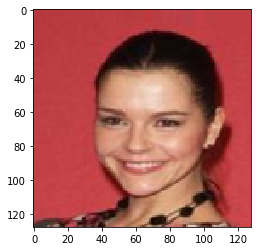

(3, 128, 128)


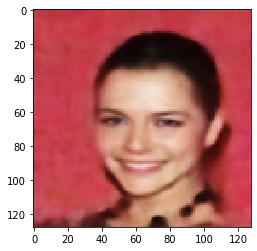

---------------- epoch =  4 / 10  ----------
Epoch 01504: reducing learning rate of group 0 to 5.4151e-04.
Epoch 01515: reducing learning rate of group 0 to 5.3609e-04.
Epoch 01526: reducing learning rate of group 0 to 5.3073e-04.
Epoch 01537: reducing learning rate of group 0 to 5.2543e-04.
Epoch 01548: reducing learning rate of group 0 to 5.2017e-04.
Epoch 01559: reducing learning rate of group 0 to 5.1497e-04.
Epoch 01570: reducing learning rate of group 0 to 5.0982e-04.
Epoch 01581: reducing learning rate of group 0 to 5.0472e-04.
Epoch 01592: reducing learning rate of group 0 to 4.9967e-04.
Epoch 01603: reducing learning rate of group 0 to 4.9468e-04.
Epoch 01614: reducing learning rate of group 0 to 4.8973e-04.
Epoch 01625: reducing learning rate of group 0 to 4.8483e-04.
Epoch 01636: reducing learning rate of group 0 to 4.7998e-04.
Epoch 01647: reducing learning rate of group 0 to 4.7519e-04.
Epoch 01658: reducing learning rate of group 0 to 4.7043e-04.
Epoch 01669: reducing lea

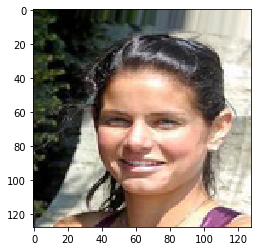

(3, 128, 128)


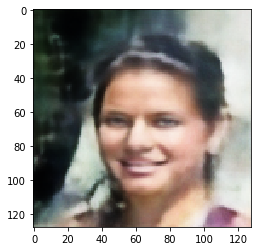

---------------- epoch =  5 / 10  ----------
Epoch 02010: reducing learning rate of group 0 to 3.4105e-04.
Epoch 02021: reducing learning rate of group 0 to 3.3764e-04.
Epoch 02032: reducing learning rate of group 0 to 3.3427e-04.
Epoch 02043: reducing learning rate of group 0 to 3.3093e-04.
Epoch 02054: reducing learning rate of group 0 to 3.2762e-04.
Epoch 02065: reducing learning rate of group 0 to 3.2434e-04.
Epoch 02076: reducing learning rate of group 0 to 3.2110e-04.
Epoch 02087: reducing learning rate of group 0 to 3.1789e-04.
Epoch 02098: reducing learning rate of group 0 to 3.1471e-04.
Epoch 02109: reducing learning rate of group 0 to 3.1156e-04.
Epoch 02120: reducing learning rate of group 0 to 3.0844e-04.
Epoch 02131: reducing learning rate of group 0 to 3.0536e-04.
Epoch 02142: reducing learning rate of group 0 to 3.0231e-04.
Epoch 02153: reducing learning rate of group 0 to 2.9928e-04.
Epoch 02164: reducing learning rate of group 0 to 2.9629e-04.
Epoch 02175: reducing lea

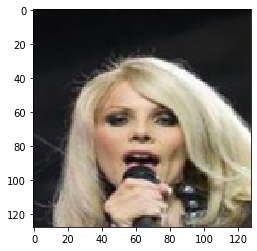

(3, 128, 128)


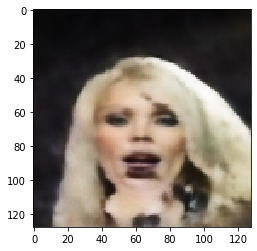

---------------- epoch =  6 / 10  ----------
Epoch 02505: reducing learning rate of group 0 to 2.1697e-04.
Epoch 02516: reducing learning rate of group 0 to 2.1480e-04.
Epoch 02527: reducing learning rate of group 0 to 2.1266e-04.
Epoch 02538: reducing learning rate of group 0 to 2.1053e-04.
Epoch 02549: reducing learning rate of group 0 to 2.0842e-04.
Epoch 02560: reducing learning rate of group 0 to 2.0634e-04.
Epoch 02571: reducing learning rate of group 0 to 2.0428e-04.
Epoch 02582: reducing learning rate of group 0 to 2.0223e-04.
Epoch 02593: reducing learning rate of group 0 to 2.0021e-04.
Epoch 02604: reducing learning rate of group 0 to 1.9821e-04.
Epoch 02615: reducing learning rate of group 0 to 1.9623e-04.
Epoch 02626: reducing learning rate of group 0 to 1.9427e-04.
Epoch 02637: reducing learning rate of group 0 to 1.9232e-04.
Epoch 02648: reducing learning rate of group 0 to 1.9040e-04.
Epoch 02659: reducing learning rate of group 0 to 1.8850e-04.
Epoch 02670: reducing lea

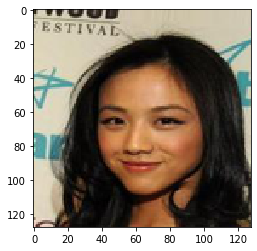

(3, 128, 128)


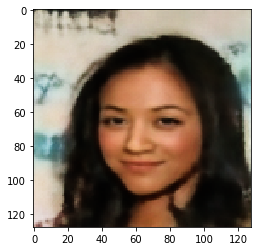

---------------- epoch =  7 / 10  ----------
Epoch 03011: reducing learning rate of group 0 to 1.3666e-04.
Epoch 03022: reducing learning rate of group 0 to 1.3529e-04.
Epoch 03033: reducing learning rate of group 0 to 1.3394e-04.
Epoch 03044: reducing learning rate of group 0 to 1.3260e-04.
Epoch 03055: reducing learning rate of group 0 to 1.3127e-04.
Epoch 03066: reducing learning rate of group 0 to 1.2996e-04.
Epoch 03077: reducing learning rate of group 0 to 1.2866e-04.
Epoch 03088: reducing learning rate of group 0 to 1.2737e-04.
Epoch 03099: reducing learning rate of group 0 to 1.2610e-04.
Epoch 03110: reducing learning rate of group 0 to 1.2484e-04.
Epoch 03121: reducing learning rate of group 0 to 1.2359e-04.
Epoch 03132: reducing learning rate of group 0 to 1.2235e-04.
Epoch 03143: reducing learning rate of group 0 to 1.2113e-04.
Epoch 03154: reducing learning rate of group 0 to 1.1992e-04.
Epoch 03165: reducing learning rate of group 0 to 1.1872e-04.
Epoch 03176: reducing lea

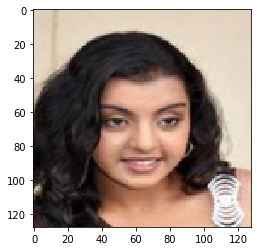

(3, 128, 128)


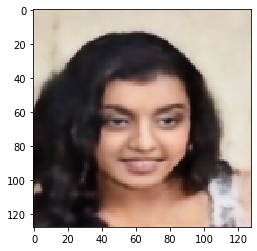

---------------- epoch =  8 / 10  ----------
Epoch 03501: reducing learning rate of group 0 to 8.7816e-05.
Epoch 03512: reducing learning rate of group 0 to 8.6938e-05.
Epoch 03523: reducing learning rate of group 0 to 8.6069e-05.
Epoch 03534: reducing learning rate of group 0 to 8.5208e-05.
Epoch 03545: reducing learning rate of group 0 to 8.4356e-05.
Epoch 03556: reducing learning rate of group 0 to 8.3513e-05.
Epoch 03567: reducing learning rate of group 0 to 8.2677e-05.
Epoch 03578: reducing learning rate of group 0 to 8.1851e-05.
Epoch 03589: reducing learning rate of group 0 to 8.1032e-05.
Epoch 03600: reducing learning rate of group 0 to 8.0222e-05.
Epoch 03611: reducing learning rate of group 0 to 7.9420e-05.
Epoch 03622: reducing learning rate of group 0 to 7.8625e-05.
Epoch 03633: reducing learning rate of group 0 to 7.7839e-05.
Epoch 03644: reducing learning rate of group 0 to 7.7061e-05.
Epoch 03655: reducing learning rate of group 0 to 7.6290e-05.
Epoch 03666: reducing lea

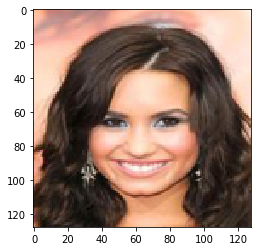

(3, 128, 128)


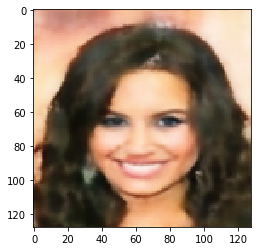

---------------- epoch =  9 / 10  ----------
Epoch 04007: reducing learning rate of group 0 to 5.5309e-05.
Epoch 04018: reducing learning rate of group 0 to 5.4756e-05.
Epoch 04029: reducing learning rate of group 0 to 5.4208e-05.
Epoch 04040: reducing learning rate of group 0 to 5.3666e-05.
Epoch 04051: reducing learning rate of group 0 to 5.3129e-05.
Epoch 04062: reducing learning rate of group 0 to 5.2598e-05.
Epoch 04073: reducing learning rate of group 0 to 5.2072e-05.
Epoch 04084: reducing learning rate of group 0 to 5.1551e-05.
Epoch 04095: reducing learning rate of group 0 to 5.1036e-05.
Epoch 04106: reducing learning rate of group 0 to 5.0526e-05.
Epoch 04117: reducing learning rate of group 0 to 5.0020e-05.
Epoch 04128: reducing learning rate of group 0 to 4.9520e-05.
Epoch 04139: reducing learning rate of group 0 to 4.9025e-05.
Epoch 04150: reducing learning rate of group 0 to 4.8535e-05.
Epoch 04161: reducing learning rate of group 0 to 4.8049e-05.
Epoch 04172: reducing lea

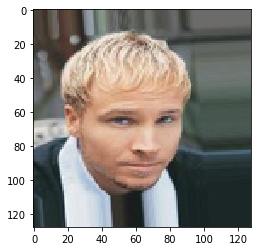

(3, 128, 128)


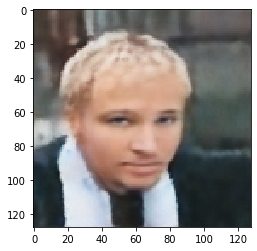

---------------- epoch =  10 / 10  ----------
Epoch 04502: reducing learning rate of group 0 to 3.5187e-05.
Epoch 04513: reducing learning rate of group 0 to 3.4835e-05.
Epoch 04524: reducing learning rate of group 0 to 3.4486e-05.
Epoch 04535: reducing learning rate of group 0 to 3.4142e-05.
Epoch 04546: reducing learning rate of group 0 to 3.3800e-05.
Epoch 04557: reducing learning rate of group 0 to 3.3462e-05.
Epoch 04568: reducing learning rate of group 0 to 3.3128e-05.
Epoch 04579: reducing learning rate of group 0 to 3.2796e-05.
Epoch 04590: reducing learning rate of group 0 to 3.2468e-05.
Epoch 04601: reducing learning rate of group 0 to 3.2144e-05.
Epoch 04612: reducing learning rate of group 0 to 3.1822e-05.
Epoch 04623: reducing learning rate of group 0 to 3.1504e-05.
Epoch 04634: reducing learning rate of group 0 to 3.1189e-05.
Epoch 04645: reducing learning rate of group 0 to 3.0877e-05.
Epoch 04656: reducing learning rate of group 0 to 3.0568e-05.
Epoch 04667: reducing le

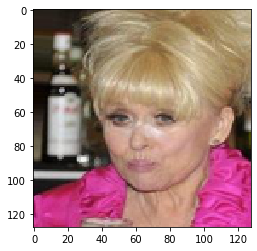

(3, 128, 128)


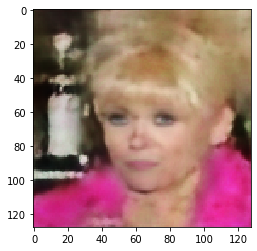

In [ ]:
net.train()
for i_epoch in range(num_epoch):
    loss_train = 0.0
    print('---------------- epoch = ', i_epoch + 1, '/',num_epoch, ' ----------')
    for i_batch, inp_train in enumerate(dataloader_train):

        inp_train = inp_train['image'].to(device) 
        # print(inp_train.shape)
        # print(inp_train)
        out_train, code_train = net(inp_train)
        out_train.sigmoid_()  # Remeber to apply it also on valid-test sets. Or move it to the mode!

        optimizer.zero_grad()
        loss = loss_function(out_train, inp_train)
        loss.backward()  
        optimizer.step()
        scheduler.step(loss)
        loss_train += loss.item()
        if i_epoch < 2:
             print(f"b({i_batch}): l = {loss.item():.3f}", end=" | ")   
    print('\n Avg train loss = ', loss_train/len(dataloader_train))
    with torch.no_grad():
        loss_valid = 0.0
        for _, inp_valid in enumerate(dataloader_valid):
            inp_valid = inp_valid['image'].to(device) 
            out_valid, code_valid = net(inp_valid)
            out_valid.sigmoid_()
            
            loss_valid += loss_function(out_valid,inp_valid).item()
        print(' Avg validation loss = ', loss_valid/len(dataloader_valid))  
        idx = 0
        D.imShow(inp_valid, idx=idx)
        D.imShow(out_valid, idx=idx)

# Note that average validation error for each epoch uses the most recent parameters, while
# the average training error is taking all updates into account.

(3, 128, 128)


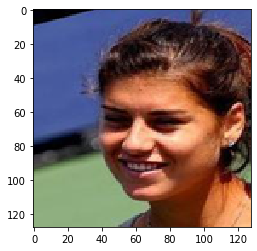

(3, 128, 128)


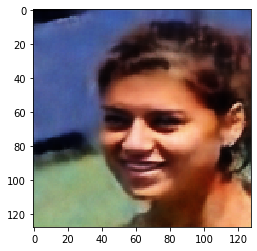

(3, 128, 128)


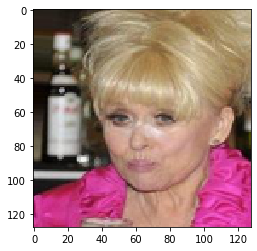

(3, 128, 128)


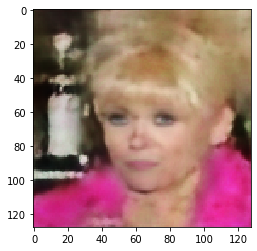

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0075, device='cuda:0')


In [ ]:
idx = 0
D.imShow(inp_train, idx=idx)
D.imShow(out_train, idx=idx)
D.imShow(inp_valid, idx=idx)
D.imShow(out_valid, idx=idx)

print(torch.norm(inp_train - out_train).pow(2)/torch.norm(inp_train).pow(2))
print(torch.norm(inp_valid - out_valid).pow(2)/torch.norm(inp_valid).pow(2))

In [ ]:
net_name = 'best_model.pth'
net_root = './weights'
now = str(datetime.timestamp(datetime.now()))

net_path = D.pathStamper(os.path.join(net_root, net_name), now)
print(net_path)
torch.save(net.state_dict(), net_path)

./weights/best_model_stmp1670216340.866353.pth


In [ ]:
model_path = './weights/best_model_stmp1670216340.866353.pth'
##########################################  Loading a trained model ##############################
num_blocks = 5
num_filts = [64, 128, 256, 512, 12]
scale_factor = [1, 1, 1, 1, 1]
num_codes = 20
neck_dim = 512
k = 128

#######
from models import Autoencoder
net = Autoencoder(img_size, num_blocks, num_filts, scale_factor, num_codes, neck_dim, k)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
net.to(device)

Autoencoder(
  (encoder): Encoder(
    (downBlocks_I): ModuleList(
      (0): downConvBlock_I(
        (resConv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): downConvBlock_I(
        (resConv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): downConvBlock_I(
        (resConv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
# Here we load only one mini-batch:

with torch.no_grad():
    for i, inp in enumerate(dataloader_test):
        try:
            inp = inp['image'].to(device) 
            out, code = net(inp)
            out.sigmoid_()
            break
        except FileNotFoundError:
            print('File not found.')

(3, 128, 128)


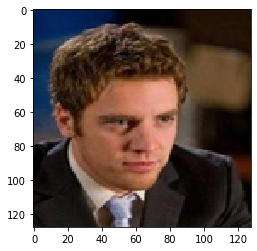

(3, 128, 128)


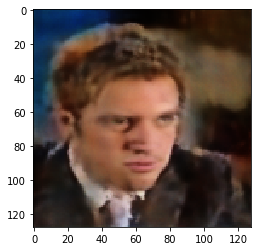

tensor(0.0124, device='cuda:0')


In [ ]:
from torchvision import utils

idx = 20 # To show
ind_i = 10  # To save
D.imShow(inp, idx=idx)
D.imShow(out, idx=idx)

print(torch.norm(inp - out).pow(2)/torch.norm(inp).pow(2))
utils.save_image(inp[ind_i:ind_i + 8,:,:,:], './output/inputs.png', nrow=8)
utils.save_image(out[ind_i:ind_i + 8,:,:,:], './output/reconstructed.png', nrow=8)

In [ ]:


# Decoding with less sparsity:
code_prime = torch.clone(code).cpu().detach()
code_prime = T.KBest(code_prime, 64)
out_prime = net.decoder(code_prime.to(device)).sigmoid_()
D.imShow(out_prime, idx=idx)
utils.save_image(out_prime[ind_i:ind_i + 8,:,:,:], './output/lessSparsity.png', nrow=8)

RuntimeError: ignored